# **Histopathological image classification using Convolutional Neural Networks** 
### DSML@2020

In this lesson you'll recognizing real images of Benign and malignant in order to classify an incoming histopathological image as one or the other. 

So, as part of the task you need to process your data -- not least resizing it to be uniform in shape. 

You'll follow these steps:

1.   Explore the Example Data of benign and malignant Histopathological images
2.   Build and Train a Deep Neural Network to classify into two categories (Benign, malignant)
3.   Evaluate the Training and Validation accuracy

The contents of the histopathological image dir is extracted to the base directory `/path_to_local-dir`, which creates `train`,`validation`, and `test` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `benign` and `malignant` subdirectories.

In short: The training set is the data that is used to tell the neural network model that 'this is what a benign images looks like', 'this is what a malignant image looks like' etc. The validation data set is images of benign and malignant histopathological images that the neural network will not see as part of the training, so you can test how well or how badly it does in evaluating if an image contains a benign or a malignant image.

One thing to pay attention to in this sample: We do not explicitly label the images as benign or malignant. If you remember with the handwriting example earlier, we had labelled 'this is a 1', 'this is a 7' etc.  Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. So, for example, you will have a 'training' directory containing a 'benign' directory and a 'malignant' one. ImageGenerator will label the images appropriately for you, reducing a coding step. 

Let's define each of these directories:

In [47]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Explore the Example Data**

Split the data into tain and validation subdirectories

In [48]:
import splitfolders  # or import split_folders

# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
input_folder = '/home/ulle/BreCan/data/CNN_400X/'
split_folder = '/home/ulle/BreCan/data/DataSplit/'
splitfolders.ratio(input_folder, output= split_folder, seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 1176 files [00:41, 28.48 files/s]


In [49]:
base_dir = '/home/ulle/BreCan/data/DataSplit/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

# Directory with our training cat pictures
train_benign_dir = os.path.join(train_dir, 'benign')

# Directory with our training dog pictures
train_malignant_dir = os.path.join(train_dir, 'malignant')

# Directory with our validation cat pictures
validation_benign_dir = os.path.join(validation_dir, 'benign')

# Directory with our validation dog pictures
validation_malignant_dir = os.path.join(validation_dir, 'malignant')

Now, let's see what the filenames look like in the `benign` and `malignant` `train` directories (file naming conventions are the same in the `validation` directory):

In [50]:
train_benign_fnames = os.listdir( train_benign_dir )
train_malignant_fnames = os.listdir( train_malignant_dir )

print('Training images from Benign folder:\n\n',train_benign_fnames[:10])
print('\nTraining images from Malignant folder:\n\n',train_malignant_fnames[:10])

Training images from Benign folder:

 ['SOB_B_TA-14-19854C-400-014.png', 'SOB_B_PT-14-21998AB-400-052.png', 'SOB_B_A-14-22549CD-400-030.png', 'SOB_B_TA-14-21978AB-400-007.png', 'SOB_B_A-14-22549CD-400-024.png', 'SOB_B_F-14-23060AB-400-015.png', 'SOB_B_F-14-21998EF-400-006.png', 'SOB_B_F-14-25197-400-044.png', 'SOB_B_A-14-22549CD-400-005.png', 'SOB_B_F-14-9133-400-016.png']

Training images from Malignant folder:

 ['SOB_M_DC-14-11951-400-015.png', 'SOB_M_DC-14-3909-400-012.png', 'SOB_M_DC-14-14926-400-006.png', 'SOB_M_DC-14-13993-400-016.png', 'SOB_M_DC-14-5695-400-013.png', 'SOB_M_DC-14-13993-400-015.png', 'SOB_M_DC-14-4364-400-007.png', 'SOB_M_DC-14-3909-400-014.png', 'SOB_M_DC-14-15696-400-015.png', 'SOB_M_DC-14-12312-400-035.png']


Let's find out the total number of benign and malignant images in the `train` and `validation` directories:

In [51]:
print('total training benign images :', len(os.listdir(      train_benign_dir ) ))
print('total training malignant images :', len(os.listdir(      train_malignant_dir ) ))

print('total validation benign images :', len(os.listdir( validation_benign_dir ) ))
print('total validation malignant images :', len(os.listdir( validation_malignant_dir ) ))

total training benign images : 470
total training malignant images : 470
total validation benign images : 118
total validation malignant images : 118


Now let's take a look at a few pictures to get a better sense of what the bening and malignant datasets look like. First, configure the matplot parameters:

In [52]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

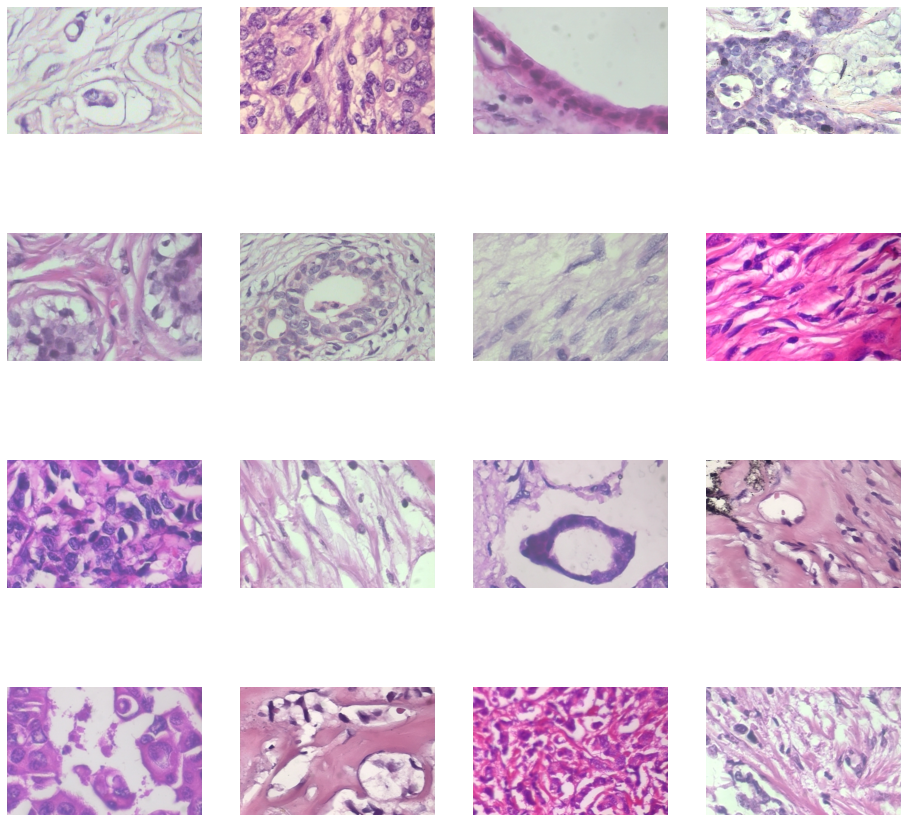

In [53]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_benign_pix = [os.path.join(train_benign_dir, fname) 
                for fname in train_benign_fnames[ pic_index-8:pic_index] 
               ]

next_malignant_pix = [os.path.join(train_malignant_dir, fname) 
                for fname in train_malignant_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_benign_pix+next_malignant_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes tf.keras.layers.Conv2D(16, (3,3), activatio(or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

tf.keras.layers.Conv2D(16, (3,3), activatioIt may not be obvious from looking at the images in this grid, but an important note here, and a significant difference from the previous lesson is that these images come in all shapes and sizes. When you did the handwriting recognition example, you had 28x28 greyscale images to work with. These are color and in a variety of shapes. Before training a Neural network with them you'll need to tweak the images. You'll see that in the next section.

Ok, now that you have an idea for what your data looks like, the next step is to define the model that will be trained to recognize benign or malignant from these images 

## **Building a Small Model from Scratch to Get to ~80-84% Accuracy**

In the previous section you saw that the images were in a variety of shapes and sizes. In order to train a neural network to handle them you'll need them to be in a uniform size. We've chosen 150x150 for this, and you'll see the code that preprocesses the images to that shape shortly. 

But before we continue, let's start defining the model:
The first step is to import libraries

Step 1 will be to import tensorflow.

Next we will define a Sequential layer as before, adding some convolutional layers first. Note the input shape parameter this time. In the earlier example it was 28x28x1, because the image was 28x28 in greyscale (8 bits, 1 byte for color depth). This time it is 150x150 for the size and 3 (24 bits, 3 bytes) for the color depth. 


We then add a couple of convolutional layers as in the previous example, and flatten the final result to feed into the densely connected layers.

Finally we add the densely connected layers. 

Note that because we are facing a two-class classification problem, i.e. a *binary classification problem*, we will end our network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function), so that the output of our network will be a single scalar between 0 and 1, encoding the probability that the current image is class 1 (as opposed to class 0).

We start using two-step appraoch:
    
1) Using standard MLP 

2) Using CNN - CONV-POOL-CONV-POOL

**MLP approach**

In [84]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8,activation='relu',input_shape=(64,64,3)),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(50, activation='relu'),     
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

In [85]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 64, 64, 8)         32        
_________________________________________________________________
flatten_13 (Flatten)         (None, 32768)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 50)                1638450   
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 1,638,533
Trainable params: 1,638,533
Non-trainable params: 0
_________________________________________________________________


The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [86]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit`, `evaluate_generator`, and `predict_generator`.

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(64, 64))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (64, 64))

Found 940 images belonging to 2 classes.
Found 236 images belonging to 2 classes.


### Training
Let's train on all 4,428 images available, for 15 epochs, and validate on all 553 test images. (This may take a few minutes to run.)

Do note the values per epoch.

You'll see 4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy. 

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. The Validation accuracy is the measurement with the data that has not been used in training. As expected this would be a bit lower. You'll learn about why this occurs in the section on overfitting later in this course.


In [88]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=50,
                              epochs=2,
                              validation_steps=20,
                              verbose=1)

Epoch 1/2
50/50 [==============================] - 25s 501ms/step - loss: 0.9268 - accuracy: 0.6670 - val_loss: 0.5762 - val_accuracy: 0.7626
Epoch 2/2
50/50 [==============================] - 16s 329ms/step - loss: 0.6060 - accuracy: 0.7380 - val_loss: 0.8417 - val_accuracy: 0.4923


### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

In [1]:
%%capture
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

**Using CNN appraoch**

In [90]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2,2),  
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2,2),        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')                                 
    
])

In [91]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               627300    
_________________________________________________________________
dense_38 (Dense)             (None, 1)               

The "output shape" column shows how the size of your feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [92]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [93]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=100,
                              epochs=5,
                              validation_steps=50,
                              verbose=1)

Epoch 1/5
100/100 [==============================] - 29s 289ms/step - loss: 0.5874 - accuracy: 0.7140 - val_loss: 0.4730 - val_accuracy: 0.8191
Epoch 2/5
100/100 [==============================] - 28s 281ms/step - loss: 0.4854 - accuracy: 0.7830 - val_loss: 0.3650 - val_accuracy: 0.8354
Epoch 3/5
100/100 [==============================] - 27s 266ms/step - loss: 0.4489 - accuracy: 0.7760 - val_loss: 0.3807 - val_accuracy: 0.7937
Epoch 4/5
100/100 [==============================] - 34s 342ms/step - loss: 0.4192 - accuracy: 0.7925 - val_loss: 0.4654 - val_accuracy: 0.7917
Epoch 5/5
100/100 [==============================] - 29s 293ms/step - loss: 0.3942 - accuracy: 0.8080 - val_loss: 0.3106 - val_accuracy: 0.8516


### Evaluating Accuracy and Loss for the Model

Let's plot the training/validation accuracy and loss as collected during training:

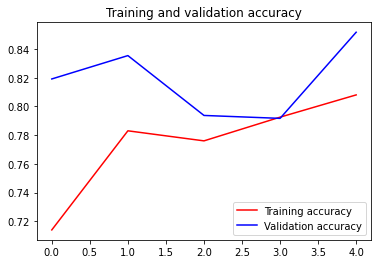

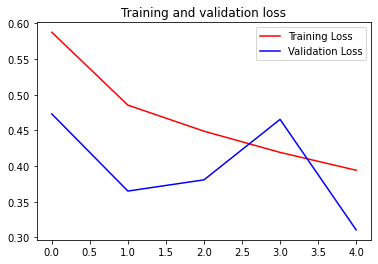

In [94]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Congratulations!!!** for coming this far. Now you have a clear understanding of the classifying medical images using `Convolutional Neural Networks`